# Data Reduction

### 1. Basic Settings

In [1]:
import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pylab as plt
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from astropy import units as u
from astropy.modeling.models import Chebyshev1D
from specutils.fitting.continuum import fit_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from scipy.optimize import curve_fit
from scipy.stats.stats import pearsonr
from scipy.interpolate import interp1d
from scipy.signal import correlate
import statsmodels.api as sm


C:\Users\23661\AppData\Local\Temp\ipykernel_14976\303231808.py:13: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
# change plotting defaults
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')
plt.rcParams['figure.figsize'] = (17, 7)

### 2. Process Data from BFOSC

In [3]:
# normalization
wavs=[]
spec=[]
spec_fit=[]
spec_fitted=[]
spec_norm=[]
for i in range(27):
    string='bfosc_data/AT2022jrp-'+str(i)+'_bfosc_20220513.txt'
    file=ascii.read(string)
    wavs.append(file['col1'])
    spec.append(file['col2'])
    region=[(5000*u.Angstrom,6500*u.Angstrom),\
    (6600*u.Angstrom,np.max(wavs[i])*u.angstrom)]
    spectrum=Spectrum1D(flux=spec[i]*u.ct,spectral_axis=wavs[i]*u.Angstrom)
    spec_fit.append(fit_continuum(spectrum,window=region,model=Chebyshev1D(5)))
    spec_fitted.append(spec_fit[i](wavs[i]*u.Angstrom))
    spec_norm.append((spec[i]/spec_fitted[i]).value)

In [4]:
# define the function for fitting
def gaussian(x, *params):
    amp, x0, sigma = params
    gauss = amp*np.exp(-1/2*((x-x0)/sigma)**2)
    return gauss

In [5]:
# Gaussian fit
wavs0=[]
wavs0_sigma=[]
guess=[1.75,6550,2.5]
bounds = ((0, 6400, 0), (np.inf,6800, np.inf))

for j in range(27):
    spec_use=[]
    wavs_use=[]
    
    for i in range(len(wavs[j])):
        if(wavs[j][i]>=6000 and wavs[j][i]<=7000):
            wavs_use.append(wavs[j][i])
            spec_use.append(spec_norm[j][i])
    
    popt, pcov = curve_fit(gaussian, wavs_use,spec_use-np.ones(len(spec_use)),p0=guess,  bounds=bounds)   
    wavs0.append(popt[1])
    wavs0_sigma.append(popt[2])

In [6]:
# read JD time of spectrum
# 'JD.txt' comes from our group member Zheng Qian's great job
file=ascii.read('./bfosc_data/JD.txt')
JD_bfosc=np.array(file['JD'])

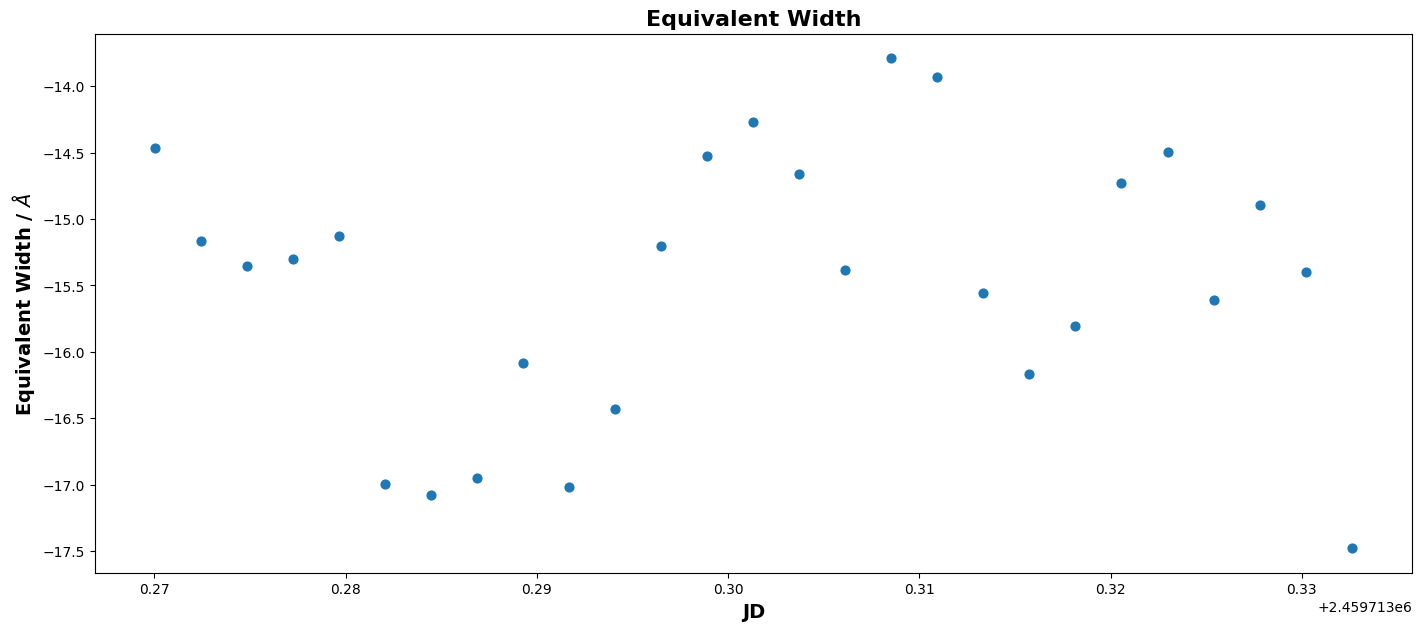

In [7]:
EW=[]
for i in range(27):
    spectrum=Spectrum1D(flux=spec_norm[i]*u.ct,spectral_axis=wavs[i]*u.Angstrom)
    EW.append(equivalent_width(spectrum,regions=SpectralRegion((wavs0[i]-3*wavs0_sigma[i])*u.Angstrom,(wavs0[i]+3*wavs0_sigma[i])*u.Angstrom)).value)

EW = np.array(EW)
plt.xlabel('JD')
plt.ylabel('Equivalent Width / '+r'$\AA$')
plt.title('Equivalent Width')
plt.scatter(JD_bfosc,EW,s=40)
# the negative value of EW represents that the line is an emission line

### 3. Process Data from AAVSO 

In [8]:
# dfg3 = pd.read_csv('aavso_data.csv')
# dfg3['JD'] = dfg3['JD'] - np.min(dfg3['JD'])
# dfg3['JD'] = dfg3['JD'] * 24*60
# plt.plot(dfg3['JD'], 10 * dfg3['Mag']-120, label='magnitude',linestyle='--', marker='o')
# JD = np.array(JD)
# EW= np.array(EW)
# plt.plot(JD+12, -EW, c='r', label='EW',linestyle='--', marker='o')
# plt.legend()
# plt.xlabel('Time/min')
# plt.ylabel('Relative value')
# plt.title('Comparison between EW and Magnitude of 2022jrp')

In [9]:
# dfg3_new = dfg3
# dfg3_new['JD'] = dfg3['JD']
# dfg3_new['Mag'] = 10 * dfg3['Mag'] - 120

In [10]:
# JD_new = JD+12
# JD_new

In [11]:
# g3_pro = np.ones(len(JD)-1, dtype=[('JD', 'f8'), ('Mag', 'f8')])
# g3_pro['JD'] = JD_new[0:-1]
# for i in range(len(JD)-1):
#     df1 = dfg3_new.query(f'JD>={JD_new[i]}')
#     df2 = dfg3_new.query(f'JD<={JD_new[i]}')
#     g3_pro['Mag'][i] = (df1['Mag'].values[0] + df2['Mag'].values[-1])/2
    

In [12]:
# mine_pro = np.ones(len(JD)-1, dtype=[('JD', 'f8'), ('EW', 'f8')])
# mine_pro['JD'] = JD_new[0:-1]
# mine_pro['EW'] = -EW[0:-1]

In [13]:
# plt.plot(g3_pro['JD'], g3_pro['Mag'], linestyle='--', marker='o')
# plt.plot(dfg3['JD'], 10 * dfg3['Mag']-120, label='magnitude',linestyle='--', marker='o')
# plt.plot(mine_pro['JD'], mine_pro['EW'], linestyle='--', marker='o')

### Process data from G3

In [9]:
df_B = pd.read_csv("./xinglong_data/Measurements_B.csv")
df_V = pd.read_csv("./xinglong_data/Measurements_V.csv")

In [10]:
JD_B = np.array(df_B['J.D.-2400000'])
JD_V = np.array(df_V['J.D.-2400000'])

# Read flux and their uncertainties of the target
T_rel_flux_B = np.array(pd.to_numeric(df_B['rel_flux_T1']))
T_flux_err_B = np.array(pd.to_numeric(df_B['rel_flux_err_T1']))

T_rel_flux_V = np.array(pd.to_numeric(df_V['rel_flux_T1']))
T_flux_err_V = np.array(pd.to_numeric(df_V['rel_flux_err_T1']))

# Read flux of comparison stars
C2_rel_flux_B = np.array(pd.to_numeric(df_B['rel_flux_C2']))
C3_rel_flux_B = np.array(pd.to_numeric(df_B['rel_flux_C3']))

C2_rel_flux_V = np.array(pd.to_numeric(df_V['rel_flux_C4']))
C3_rel_flux_V = np.array(pd.to_numeric(df_V['rel_flux_C4']))

In [11]:
# Look up the magnitudes of comparison stars (from simbad)
C2_mag_B = 12.40
C2_mag_V = 12.11
C3_mag_B = 12.17
C3_mag_V = 11.65

In [12]:
# Calculate standard magnitude in B band of the target
T_mag_B_2 = C2_mag_B - 2.5 * np.log10(T_rel_flux_B/C2_rel_flux_B)
T_mag_B_3 = C3_mag_B - 2.5 * np.log10(T_rel_flux_B/C3_rel_flux_B)
T_mag_B = (T_mag_B_2 + T_mag_B_3)/2

# Calculate standard magnitude in V band of the target
T_mag_V_2 = C2_mag_V - 2.5 * np.log10(T_rel_flux_V/C2_rel_flux_V)
T_mag_V_3 = C3_mag_V - 2.5 * np.log10(T_rel_flux_V/C3_rel_flux_V)
T_mag_V = (T_mag_V_2 + T_mag_V_3)/2

In [13]:
# Calculate uncertainties of standard magnitudes of the target
T_mag_err_B = 2.5/np.log(10) * T_flux_err_B/T_rel_flux_B

T_mag_err_V = 2.5/np.log(10) * T_flux_err_V/T_rel_flux_V

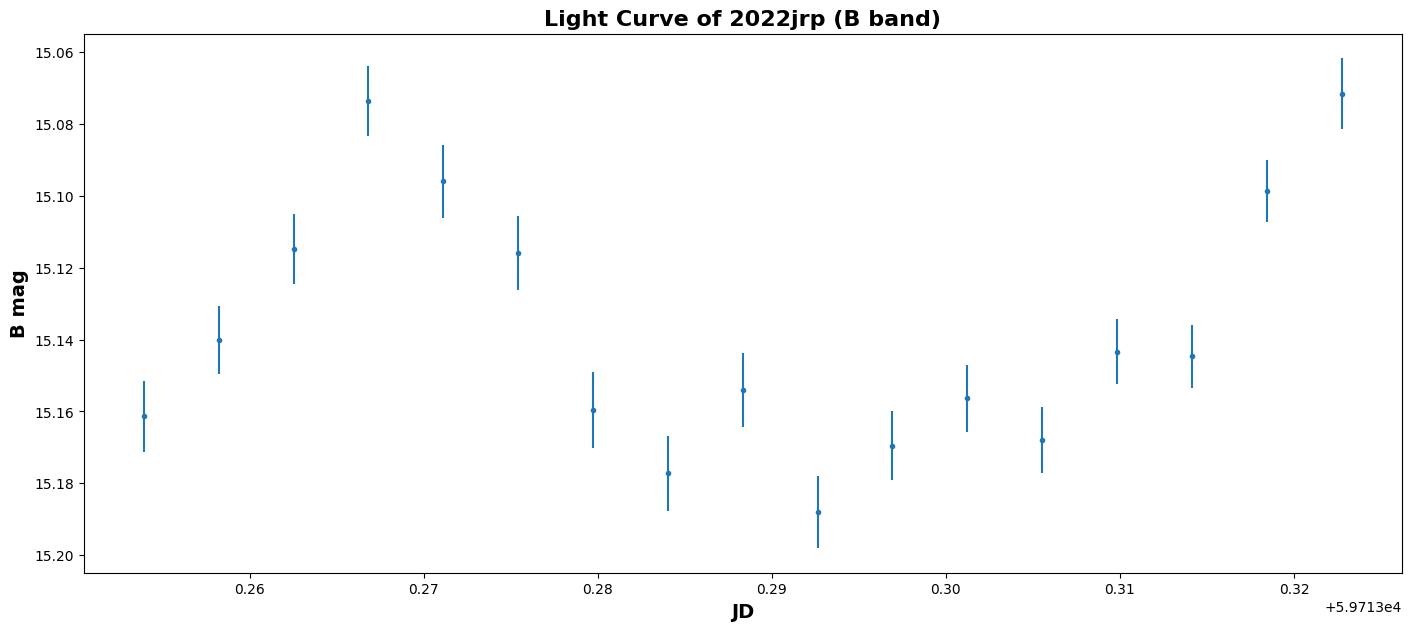

In [14]:
plt.errorbar(JD_B,T_mag_B,yerr=T_mag_err_B,fmt='.')
plt.gca().invert_yaxis() 

plt.title('Light Curve of 2022jrp (B band)')
plt.xlabel('JD')
plt.ylabel('B mag')
plt.savefig("light_curve_B.jpg", dpi=200)

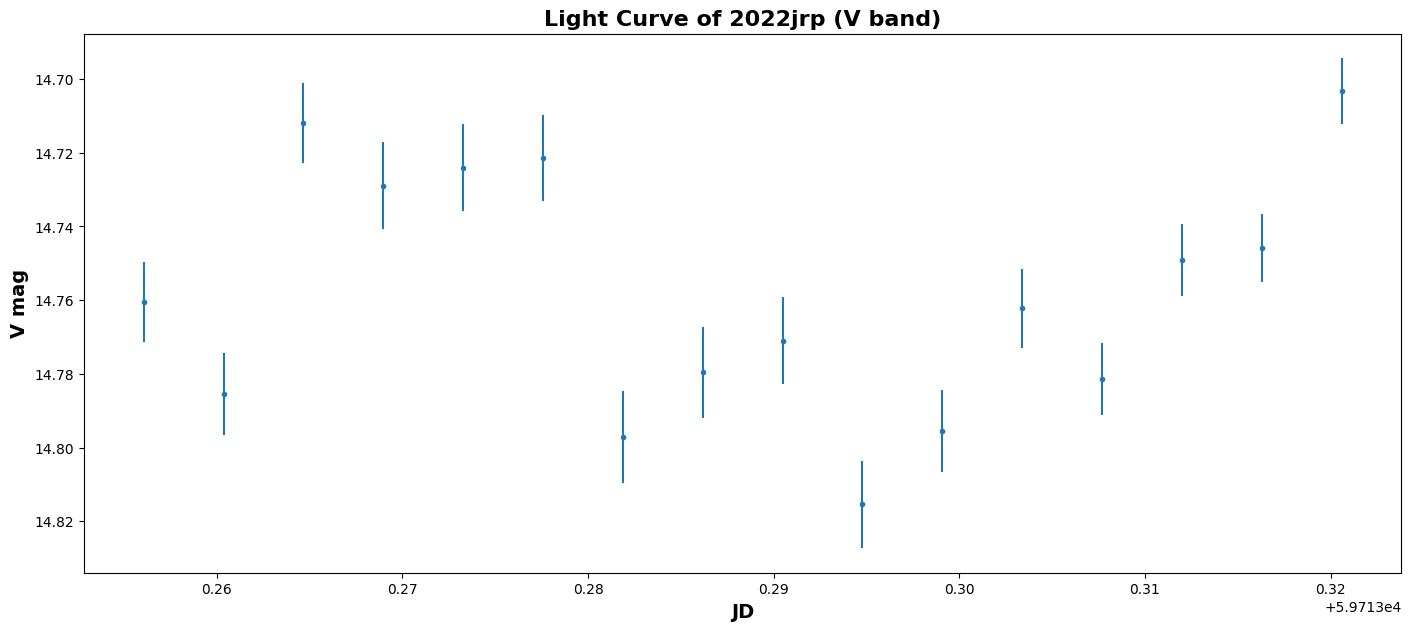

In [15]:
plt.errorbar(JD_V,T_mag_V,yerr=T_mag_err_V,fmt='.')
plt.gca().invert_yaxis()

plt.title('Light Curve of 2022jrp (V band)')
plt.xlabel('JD')
plt.ylabel('V mag')
plt.savefig("light_curve_V.jpg", dpi=200)

### Studying the relation between EW and B Magnitude

In [16]:
JD_B = JD_B + 2400000
JD_V = JD_V + 2400000

In [17]:
flux_B = 10**(T_mag_B/(-2.5))
flux_V = 10**(T_mag_V/(-2.5))

Text(0.5, 1.0, 'Comparison of EW and Magnitude Observed in Xinglong')

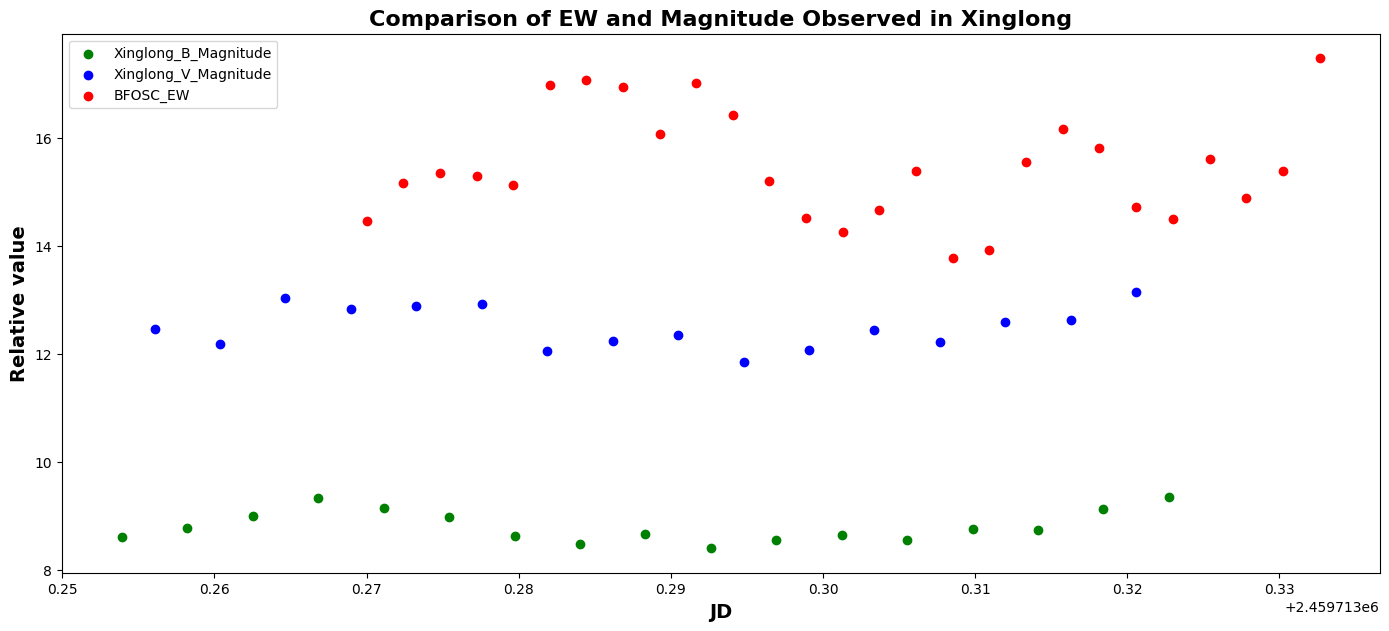

In [18]:
plt.scatter(JD_B,flux_B*10**7, c='g', label='Xinglong_B_Magnitude')
plt.scatter(JD_V,flux_V*10**7, c='b', label='Xinglong_V_Magnitude')
plt.scatter(JD_bfosc, -EW, c='r', label='BFOSC_EW')
plt.xlabel('JD')
plt.ylabel('Relative value')
plt.legend()
plt.title('Comparison of EW and Magnitude Observed in Xinglong')

Text(0.5, 1.0, 'Comparison of EW and Magnitude Observed in Xinglong')

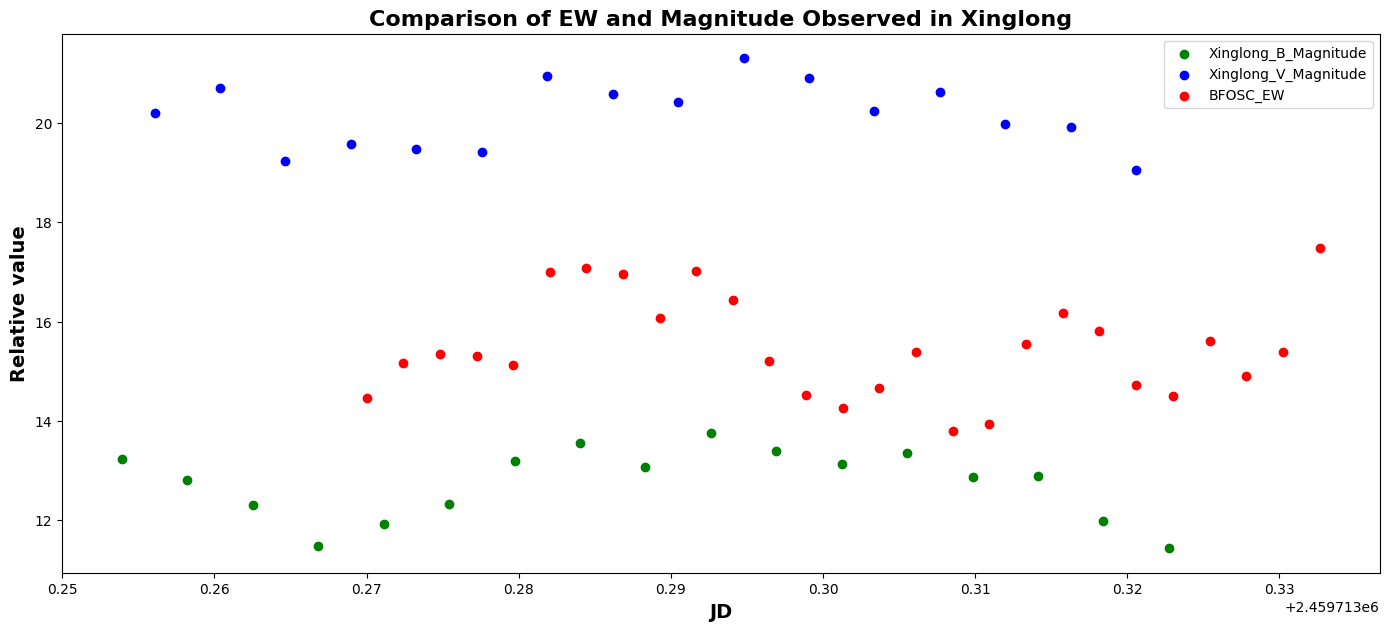

In [19]:
plt.scatter(JD_B,T_mag_B*20-290, c='g', label='Xinglong_B_Magnitude')
plt.scatter(JD_V,T_mag_V*20-275, c='b', label='Xinglong_V_Magnitude')
plt.scatter(JD_bfosc, -EW, c='r', label='BFOSC_EW')
plt.xlabel('JD')
plt.ylabel('Relative value')
plt.legend()
plt.title('Comparison of EW and Magnitude Observed in Xinglong')

In [20]:
EW_cubic = interp1d(JD_bfosc, EW, kind='cubic')


In [21]:
# 先直接interpolate，不平移时间
JD_B_proc, T_mag_B_proc = [], []
for i, jd in enumerate(JD_B):
    if jd >= JD_bfosc.min() and jd <= JD_bfosc.max():
        JD_B_proc.append(jd)
        T_mag_B_proc.append(T_mag_B[i])

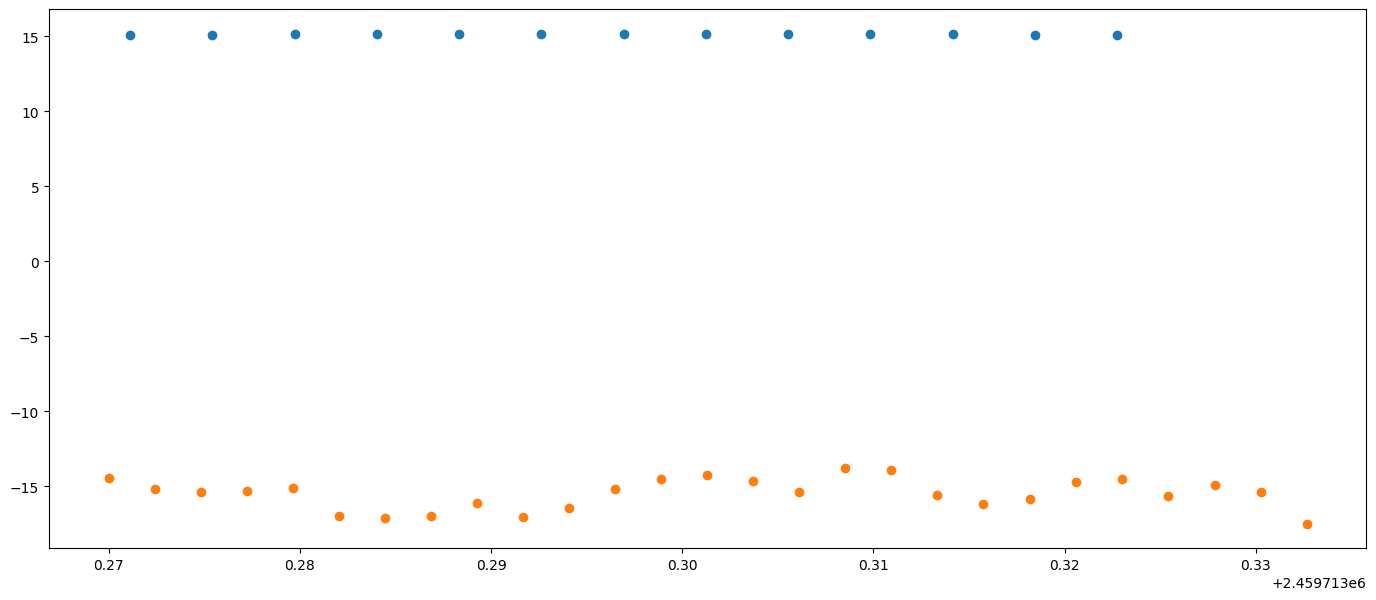

In [22]:
plt.scatter(JD_B_proc, T_mag_B_proc)
plt.scatter(JD_bfosc, EW)

In [23]:
EW_inter = EW_cubic(JD_B_proc)

In [24]:
pearsonr(EW_inter, T_mag_B_proc)

PearsonRResult(statistic=-0.4389335806409631, pvalue=0.13347830410938044)

### 尝试对EW和Magnitude做CCF

In [25]:
# interpolate B magnitude and V magnitude
T_mag_B_cubic = interp1d(JD_B, T_mag_B, kind='cubic')
T_mag_V_cubic = interp1d(JD_V, T_mag_V, kind='cubic')

In [26]:
# 对整个时间区间取10000个点，并计算B,V,EW的起止时间点
JD_ccc = np.linspace(JD_B.min(), JD_bfosc.max(), 10000)
JD_ccc_B = JD_ccc[np.where(np.logical_and(JD_ccc>=JD_B.min(), JD_ccc<=JD_B.max()))]
JD_ccc_V = JD_ccc[np.where(np.logical_and(JD_ccc>=JD_V.min(), JD_ccc<=JD_V.max()))]
JD_ccc_bfosc = JD_ccc[np.where(np.logical_and(JD_ccc>=JD_bfosc.min(), JD_ccc<=JD_bfosc.max()))]


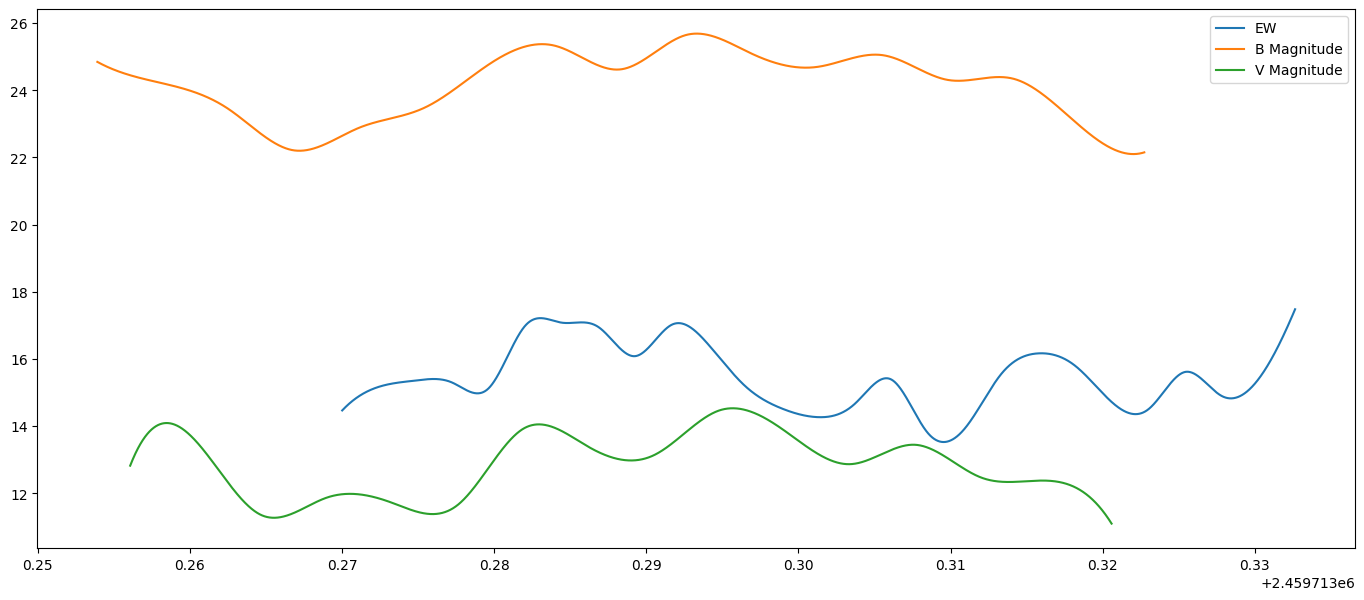

In [27]:
EW_inter = EW_cubic(JD_ccc_bfosc)
T_mag_B_inter = T_mag_B_cubic(JD_ccc_B)
T_mag_V_inter = T_mag_V_cubic(JD_ccc_V)

plt.plot(JD_ccc_bfosc, -EW_inter, label='EW')
plt.plot(JD_ccc_B, 30*T_mag_B_inter-430, label='B Magnitude')
plt.plot(JD_ccc_V, 30*T_mag_V_inter-430, label='V Magnitude')
plt.legend()

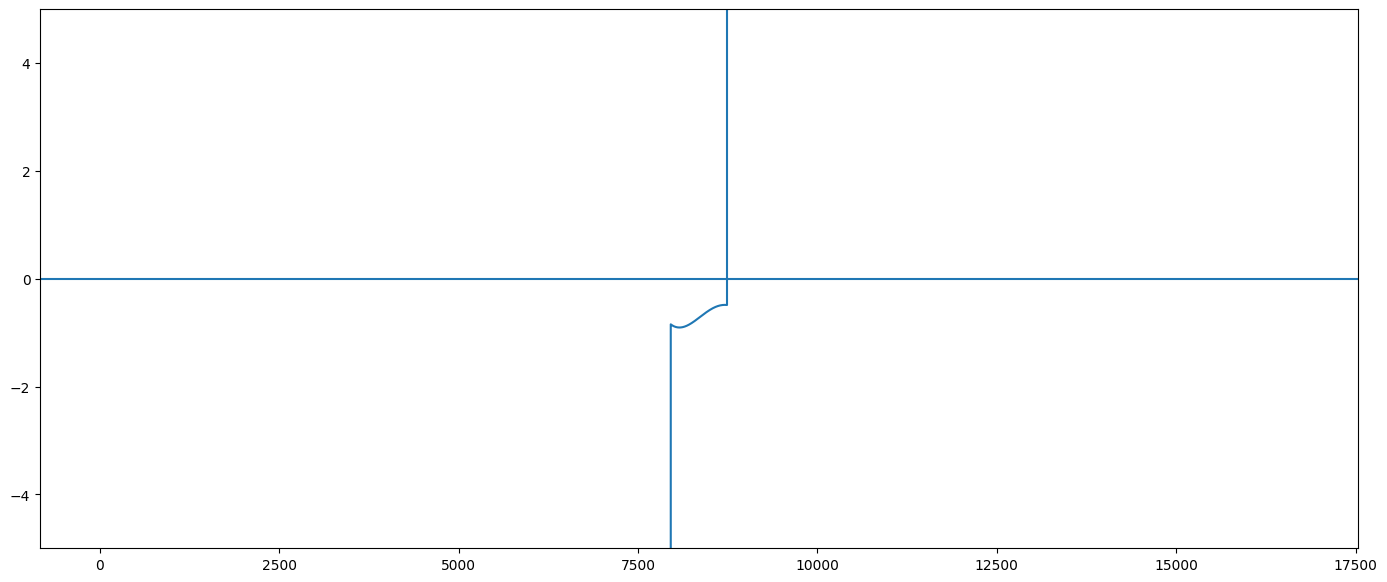

In [28]:
# plt.plot(correlate(in1=EW_inter, in2=T_mag_B_inter))
# plt.xlim(8000,8700)
# plt.ylim(-2e6,-1.75e6)

#进行correlation,计算相邻时间点的差分
result_EW_B = correlate(in1=EW_inter, in2=T_mag_B_inter)

delta_result1 = result_EW_B[1:-1] - result_EW_B[0:-2]
plt.plot(delta_result1)
plt.ylim(-5, 5)
plt.axhline(0)

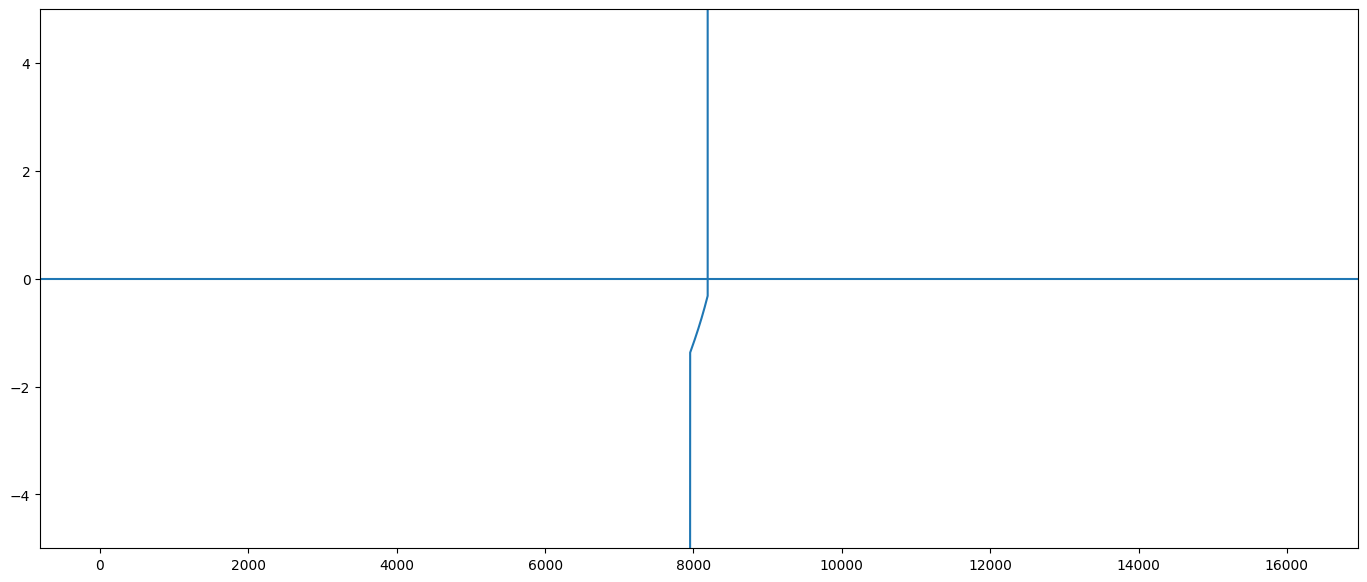

In [29]:
# 同上
result_EW_V = correlate(in1=EW_inter, in2=T_mag_V_inter)

delta_result2 = result_EW_V[1:-1] - result_EW_V[0:-2]
plt.plot(delta_result2)
plt.ylim(-5, 5)
plt.axhline(0)

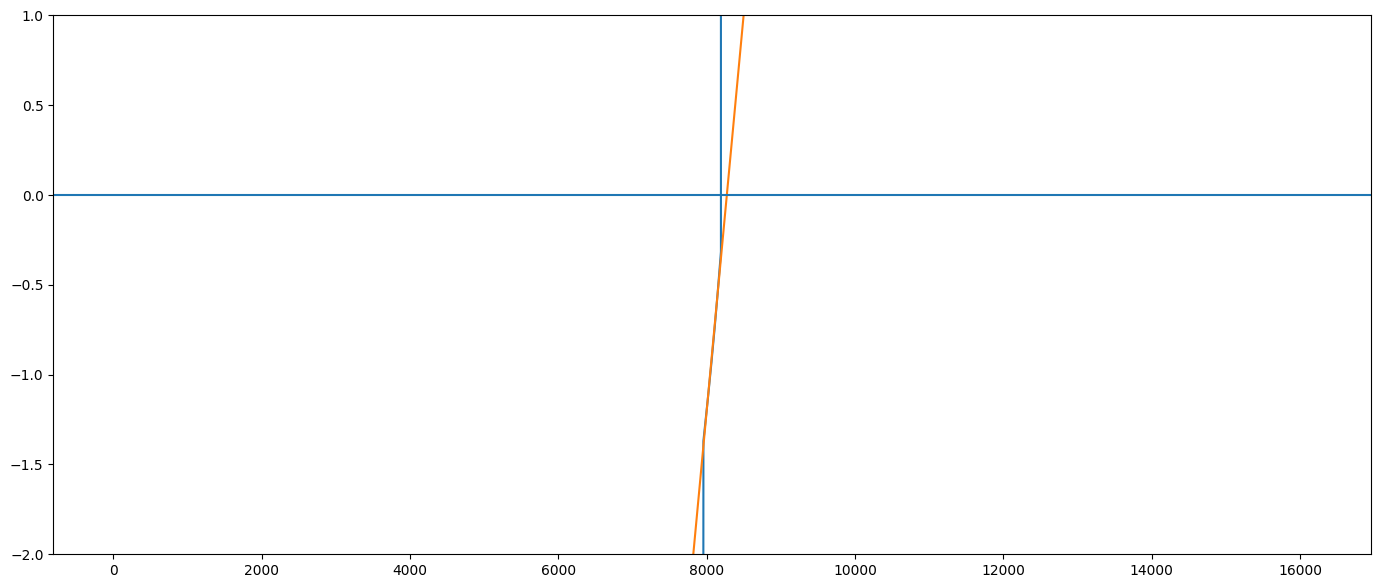

8271.759363391064


In [30]:
# 下面对V和EW进行计算。首先计算差分图中的零点（也就是极值点）
indices = np.where(np.logical_and(delta_result2>=-5, delta_result2<=5))
data = delta_result2[indices]
indi2 = np.ones(len(data), dtype=[('ccc', 'f8'), ('ddd', 'f8')])
indi2['ccc'] = indices[0]
fit = sm.OLS(data, indi2).fit()
plt.plot(delta_result2)
plt.plot(np.linspace(1,16000, 16000), fit.params[0]*np.linspace(1,16000, 16000)+fit.params[1])
plt.ylim(-2, 1)
plt.axhline(0)
plt.show()
jiaodian = -fit.params[1] / fit.params[0]
print(jiaodian)

In [31]:
# 计算需要平移的大小
start_V = np.where(JD_ccc==JD_ccc_V.min())[0][0]
start_EW = np.where(JD_ccc== JD_ccc_bfosc.min())[0][0]
delta = int(np.around(jiaodian-len(T_mag_V_inter)+(start_EW-start_V)))

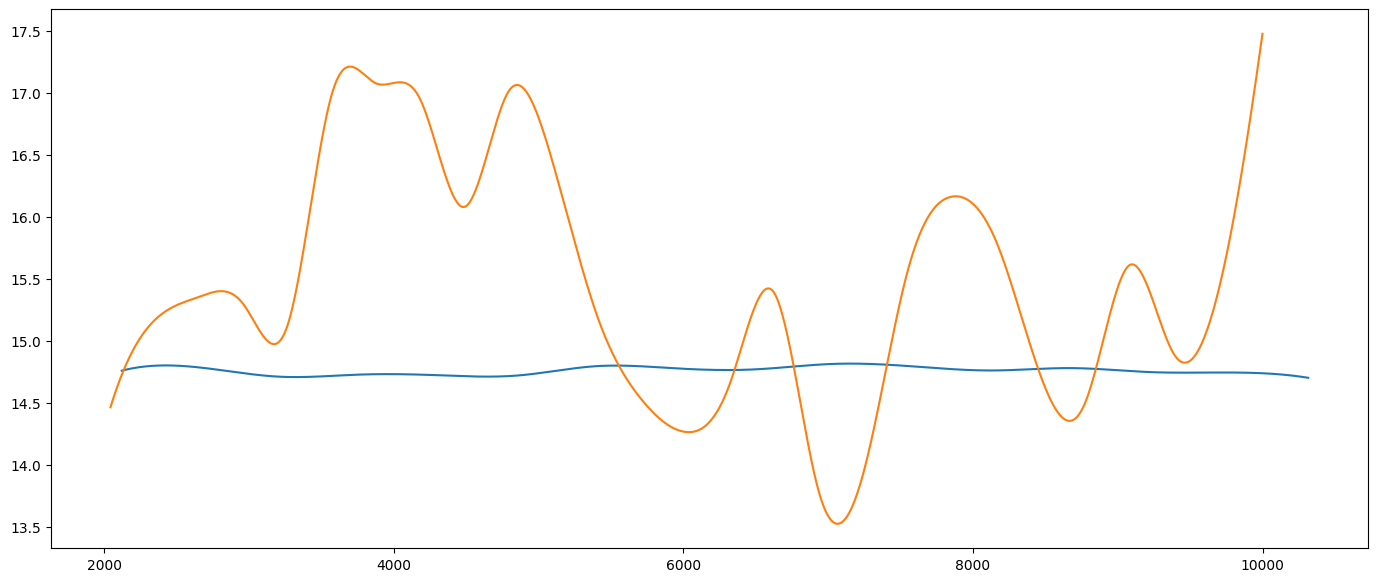

In [32]:
# 平移之后的Vmag和EW图像
time_V = np.arange(len(T_mag_V_inter))+delta+start_V
time_EW = np.arange(len(EW_inter))+start_EW
plt.plot(time_V,T_mag_V_inter)
plt.plot(time_EW,-EW_inter)


In [33]:
# 计算相关系数
pearsonr(T_mag_V_inter[0:np.where(time_V==np.max(time_EW))[0][0]], EW_inter[np.where(time_EW==np.min(time_V))[0][0]:-1])

PearsonRResult(statistic=0.6858136400557253, pvalue=0.0)

In [34]:
len(EW_inter), len(T_mag_V_inter)

(7956, 8194)

In [35]:
pearsons2 = []
for i in range(7000):
    pearsons2.append(pearsonr(EW_inter[0:min(len(EW_inter), len(T_mag_V_inter))-i], T_mag_V_inter[i:min(len(EW_inter), len(T_mag_V_inter))])[0])

In [36]:
pearsons3=[]
for i in range(7000):
    pearsons3.append(pearsonr(EW_inter[i:-1], T_mag_V_inter[0:len(EW_inter)-i-1])[0])

0.9273118430211367


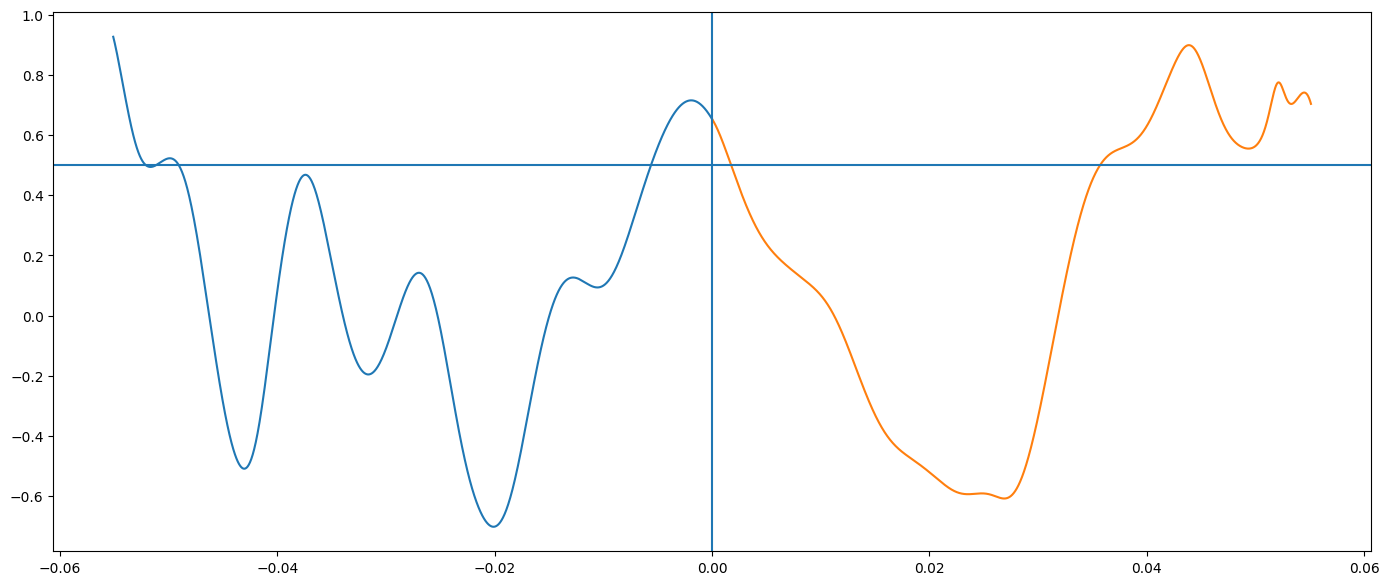

In [37]:
plt.plot(-np.arange(7000)*(-JD_B.min()+JD_bfosc.max())/10000,pearsons3)
plt.plot(np.arange(7000)*(-JD_B.min()+JD_bfosc.max())/10000,pearsons2)
print(max(pearsons3))
np.where(pearsons3==np.max(pearsons3))
plt.axvline(0)
plt.axhline(0.5)

In [38]:
delta2 = -(-JD_B.min() + JD_bfosc.max())*244/10000
print(delta2)

-0.00192107209879905


In [39]:
time_delta = JD_ccc_bfosc[0] - JD_ccc_V[0]-delta2
print(time_delta)

0.015858111865259705


In [40]:
time_delta / 0.0547

0.2899106373904882

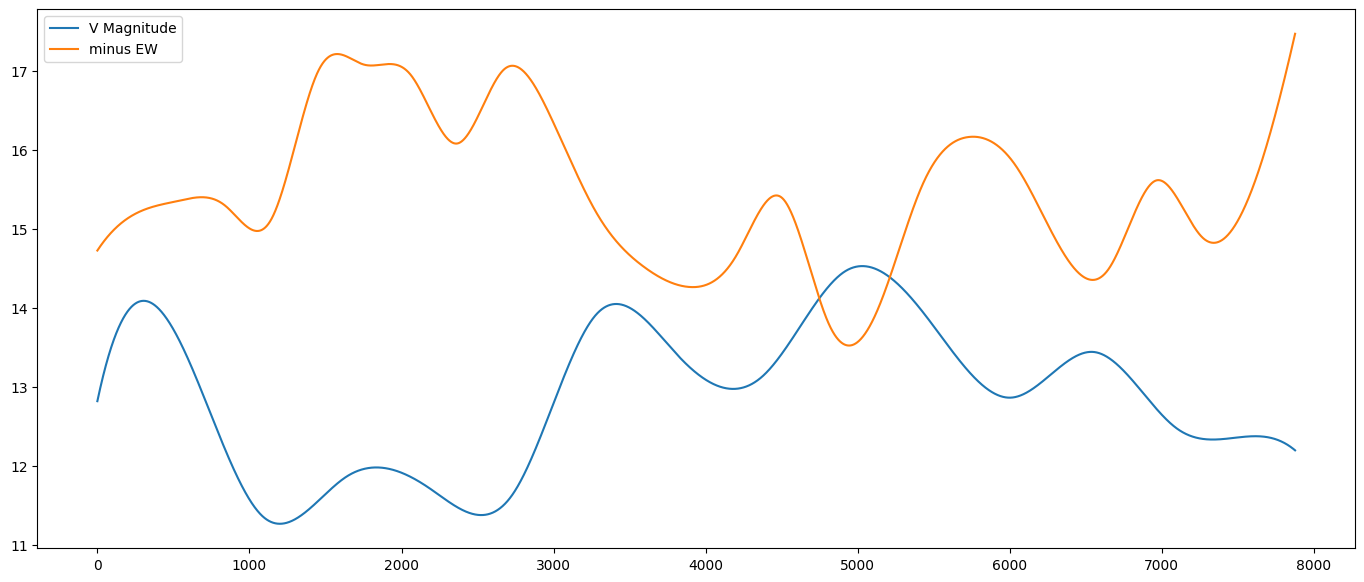

In [41]:
# 画出时间交集内的两函数图像（进行了纵向伸缩）
plt.plot(30*T_mag_V_inter[0:np.where(time_V==np.max(time_EW))[0][0]]-430, label='V Magnitude')
plt.plot(-EW_inter[np.where(time_EW==np.min(time_V))[0][0]:-1], label='minus EW')
plt.legend()

In [42]:
# 计算结果非常好！计算平移的时间（单位：JD）
delta/10000*(JD_bfosc.max()-JD_B.min())

0.014549759174510835

### 使用AAVSO的数据进行CCF

d:\Python\lib\site-packages\IPython\core\interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0, 0.5, 'Relative value')

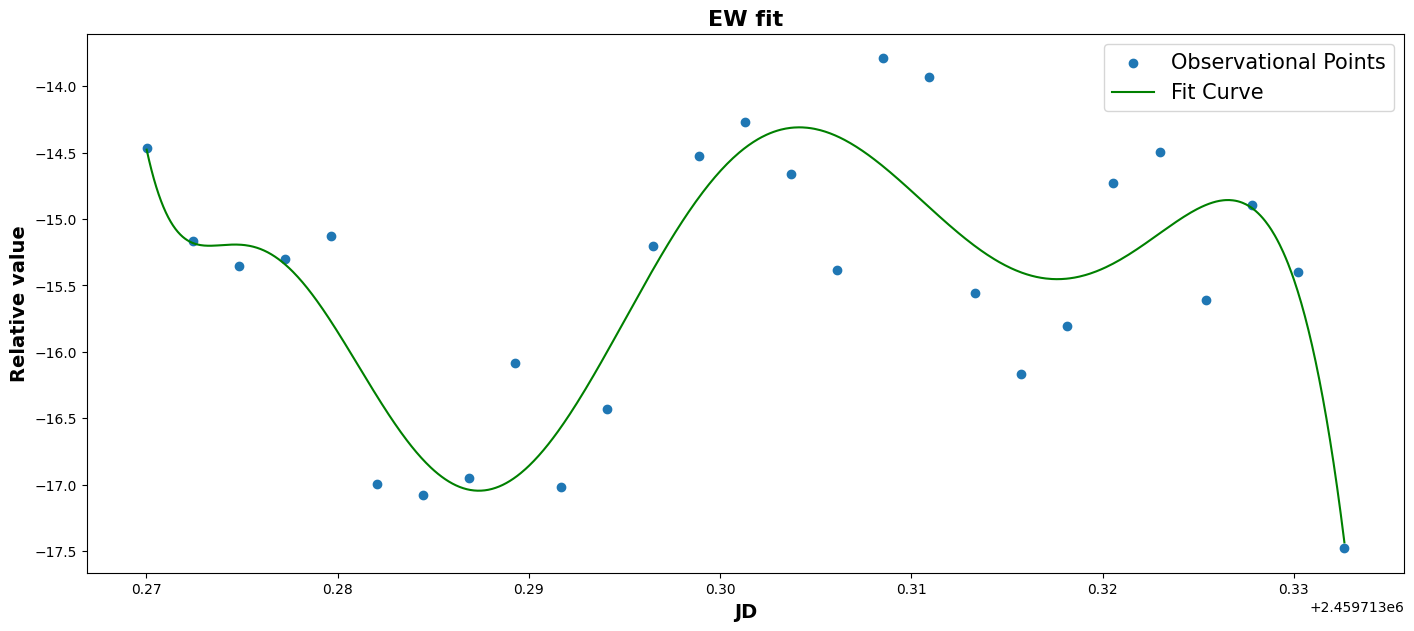

In [43]:
# 先拟合EW曲线
j0 = 2459713
EW_fit = np.poly1d(np.polyfit(JD_bfosc-j0, EW, deg=10))
plt.scatter(JD_bfosc, EW, label='Observational Points')
plt.plot(np.linspace(np.min(JD_bfosc), np.max(JD_bfosc), 1000), EW_fit(np.linspace(np.min(JD_bfosc), np.max(JD_bfosc), 1000)-j0),c='g', label='Fit Curve')
plt.legend(prop={'size': 15})
plt.title('EW fit')
plt.xlabel('JD')
plt.ylabel('Relative value')

In [44]:
df = pd.read_csv('../aavsodata_20221112.txt')
# 筛选Band为CV且Observer Code为VMT的数据
JD_vmt = np.array(df[(df['Band'] == 'CV') & (df['Observer_Code'] =="VMT")]['JD'])
Mag_vmt = np.array(pd.to_numeric(df[(df['Band'] == 'CV') & (df['Observer_Code'] =="VMT")]['Magnitude']))
Err_vmt = np.array(pd.to_numeric(df[(df['Band'] == 'CV') & (df['Observer_Code'] =="VMT")]['Uncertainty']))


In [45]:
df_use = df.query("Observer_Code=='VMT' and JD>=2459713 and JD<=2459714")

In [46]:
df_use['Magnitude'] = pd.to_numeric(df_use['Magnitude'])

C:\Users\23661\AppData\Local\Temp\ipykernel_14976\4224549387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use['Magnitude'] = pd.to_numeric(df_use['Magnitude'])


d:\Python\lib\site-packages\IPython\core\interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 1.0, 'CV Magnitude (from AAVSO) Fit')

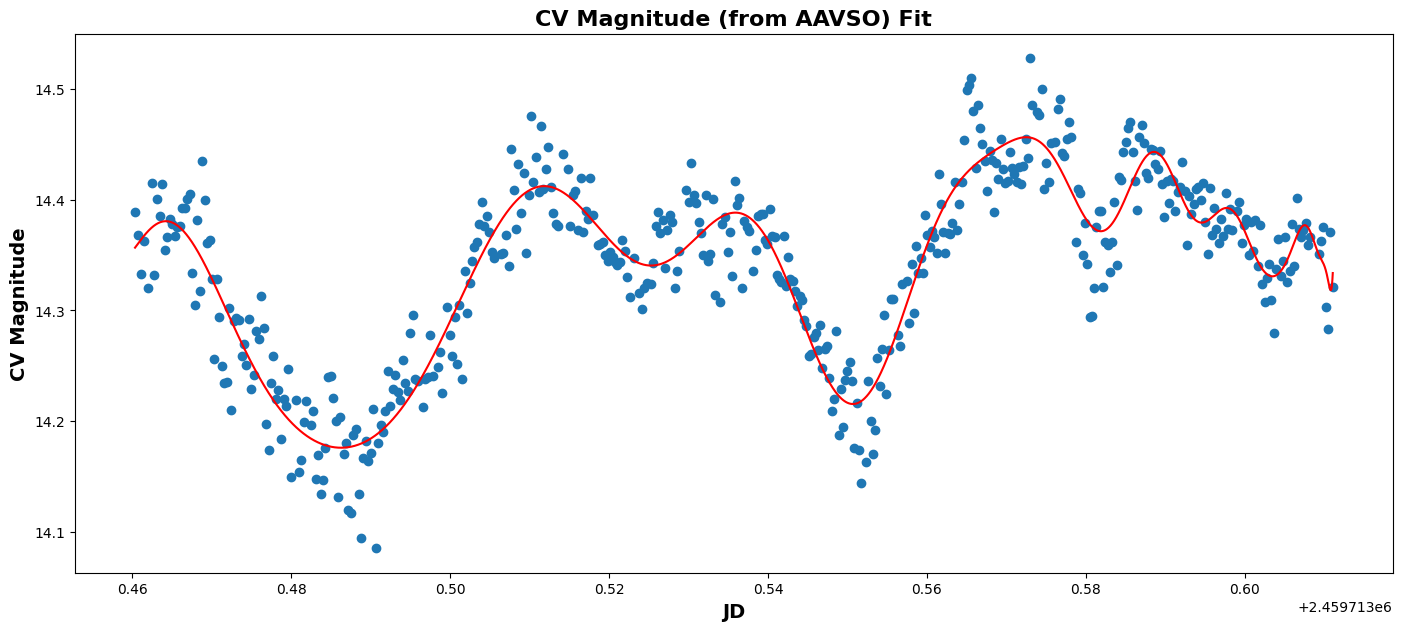

In [47]:
mingzi = np.poly1d(np.polyfit(np.array(df_use['JD']-j0), np.array(df_use['Magnitude']), 400))
JD_ccc = np.linspace(JD_bfosc.min(), df_use['JD'].max(), 10000)
shijian = np.linspace(np.min(df_use['JD']-j0), np.max(df_use['JD']-j0), 10000)
aavso_point = mingzi(shijian)
plt.plot(shijian + j0, aavso_point, c='r', label='Fit Curve')
plt.scatter(df_use['JD'], df_use['Magnitude'], label='Observational Points')
plt.xlabel('JD')
plt.ylabel('CV Magnitude')
plt.title('CV Magnitude (from AAVSO) Fit')




In [48]:
JD_ccc_bfosc = JD_ccc[np.where(np.logical_and(JD_ccc>=JD_bfosc.min(), JD_ccc<=JD_bfosc.max()))]
EW_inter = EW_fit(JD_ccc_bfosc-j0)


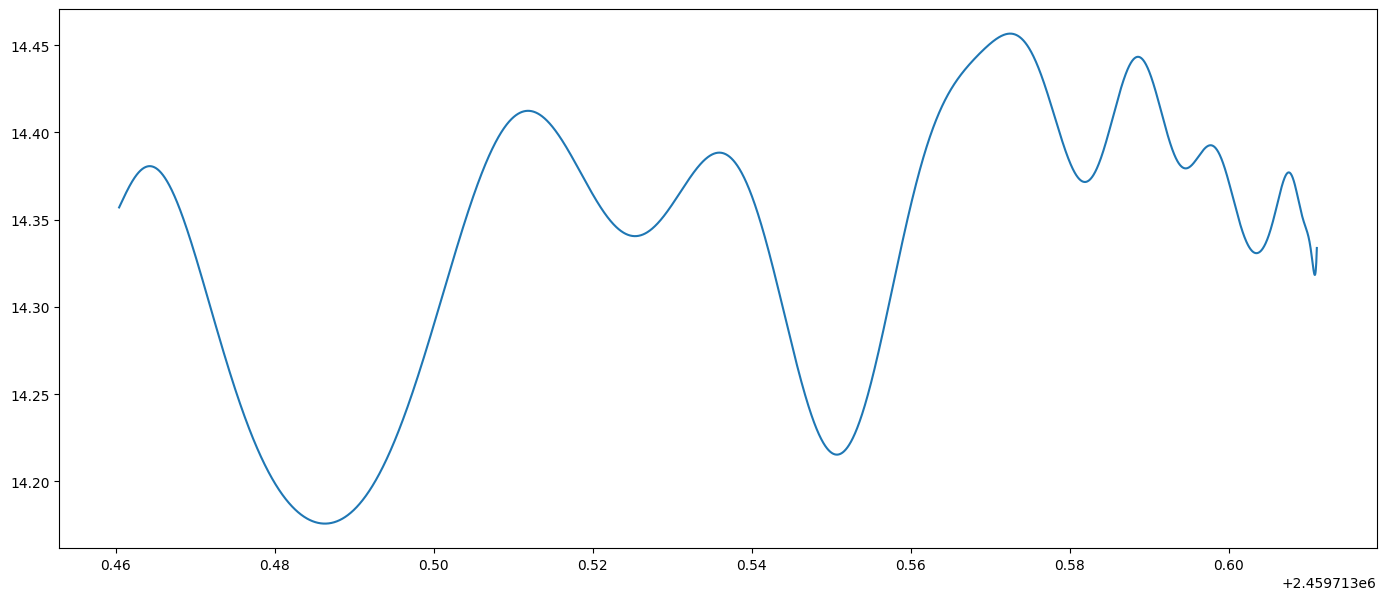

In [49]:
JD_ccc_aavso = JD_ccc[np.where(np.logical_and(JD_ccc>=df_use['JD'].min(), JD_ccc<=df_use['JD'].max()))]
aavso_point2 = mingzi(JD_ccc_aavso-j0)
plt.plot(JD_ccc_aavso, aavso_point2)

In [50]:
result_EW_aavso = correlate(in1=EW_inter, in2=aavso_point2)
# result_processed = result_EW_aavso[1:-1] - result_EW_aavso[0:-2]
# jiaodian = np.where(result_processed<0)[0][-1]
jiaodian = 9870

In [51]:
len(EW_inter)

1837

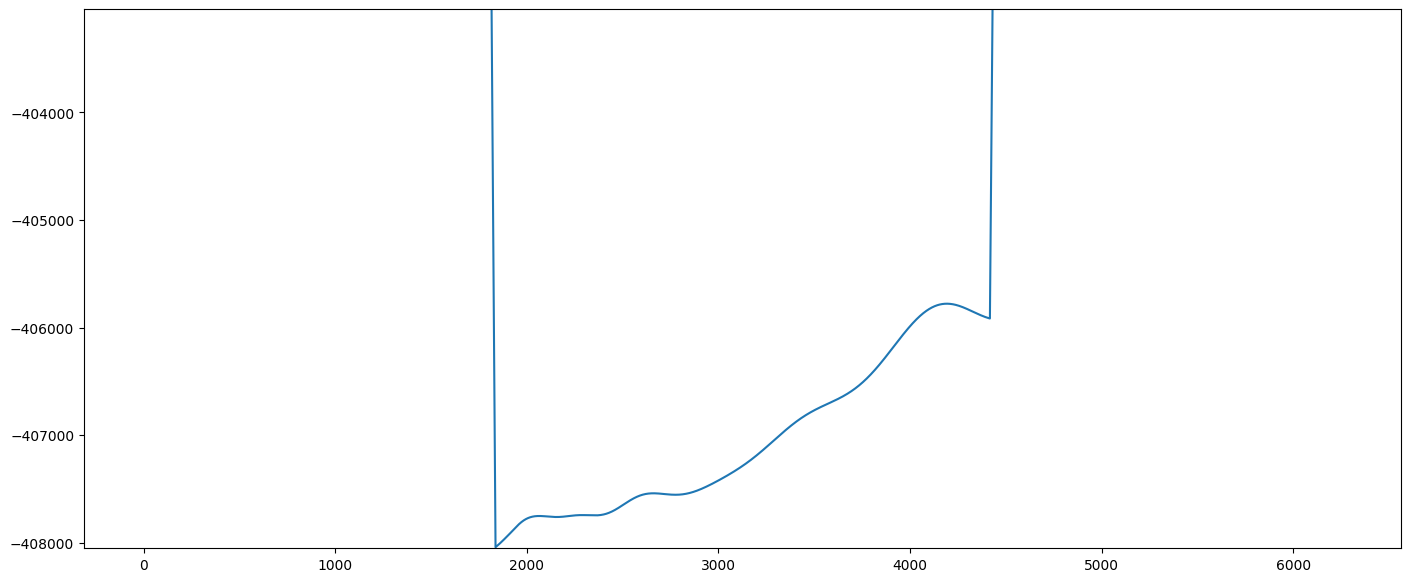

In [52]:
plt.plot(result_EW_aavso)
plt.ylim(np.min(result_EW_aavso)-10,np.min(result_EW_aavso)+5000 )
plt.axhline(0)
# plt.ylim(,5)
# plt.xlim(000, 11000)
# plt.axvline(9870)
jiaodian = np.where(result_EW_aavso==np.min(result_EW_aavso))[0][0]

In [53]:
jiaodian

1836

In [54]:
# 计算需要平移的大小
start_aavso = np.where(JD_ccc==JD_ccc_aavso.min())[0][0]
start_EW = np.where(JD_ccc== JD_ccc_bfosc.min())[0][0]
delta = int(np.around(jiaodian-len(JD_ccc_aavso)+(start_EW-start_aavso)))

In [55]:
delta

-8164

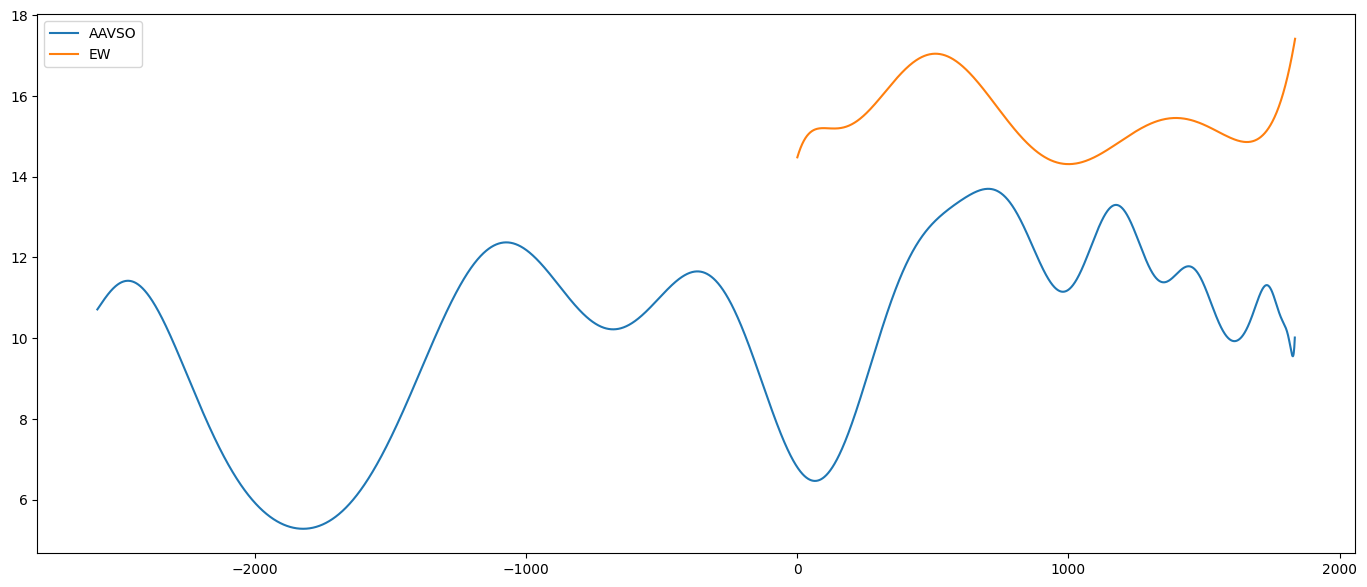

In [56]:
# 平移之后的Vmag和EW图像
time_aavso = np.arange(len(JD_ccc_aavso))+delta+start_aavso
time_EW = np.arange(len(EW_inter))+start_EW
plt.plot(time_aavso, 30*aavso_point2-420, label='AAVSO')
plt.plot(time_EW,-EW_inter, label='EW')
plt.legend()


Text(0.5, 0, 'index (uniformly sampled)')

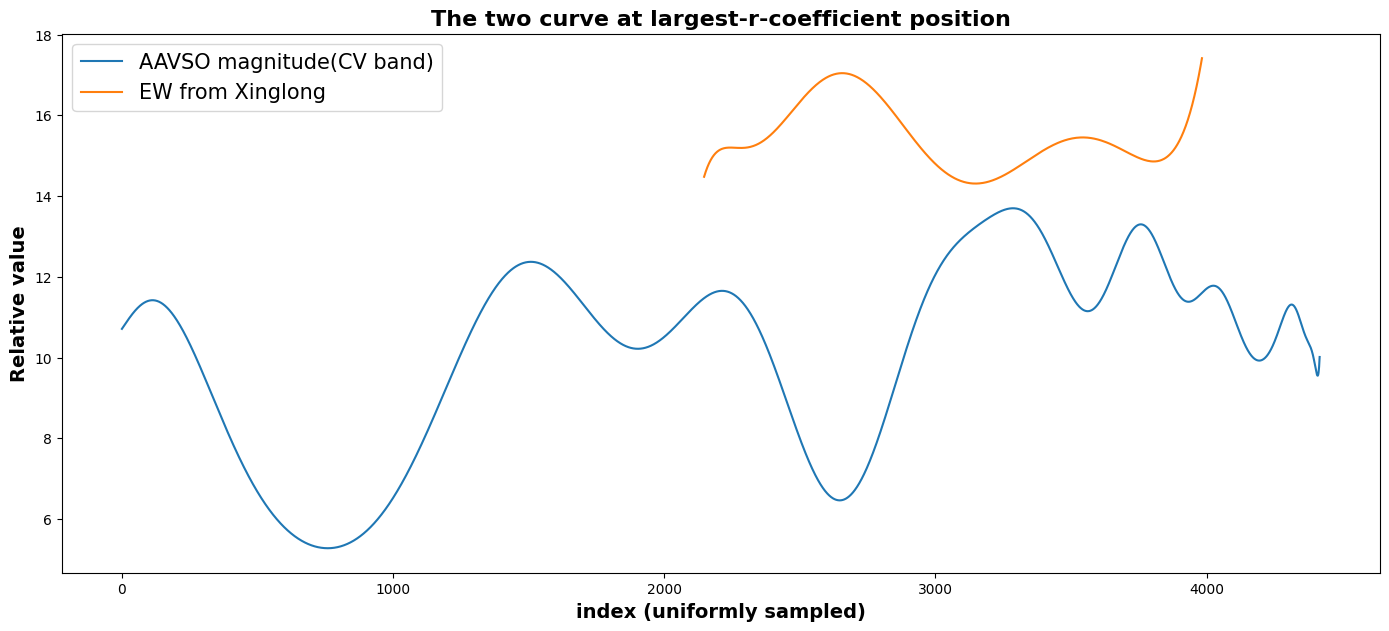

In [57]:
# 平移之后的Vmag和EW图像
time_aavso = np.arange(len(JD_ccc_aavso))
time_EW = np.arange(len(EW_inter))+2147
plt.plot(time_aavso, 30*aavso_point2-420, label='AAVSO magnitude(CV band)')
plt.plot(time_EW,-EW_inter, label='EW from Xinglong')
plt.legend(prop={'size':15})
plt.title('The two curve at largest-r-coefficient position')
plt.ylabel('Relative value')
plt.xlabel('index (uniformly sampled)')


In [58]:
pearsons = []
for i in range(-len(EW_inter)+len(aavso_point2)):
    pearsons.append(pearsonr(EW_inter, aavso_point2[i:i+len(EW_inter)])[0])

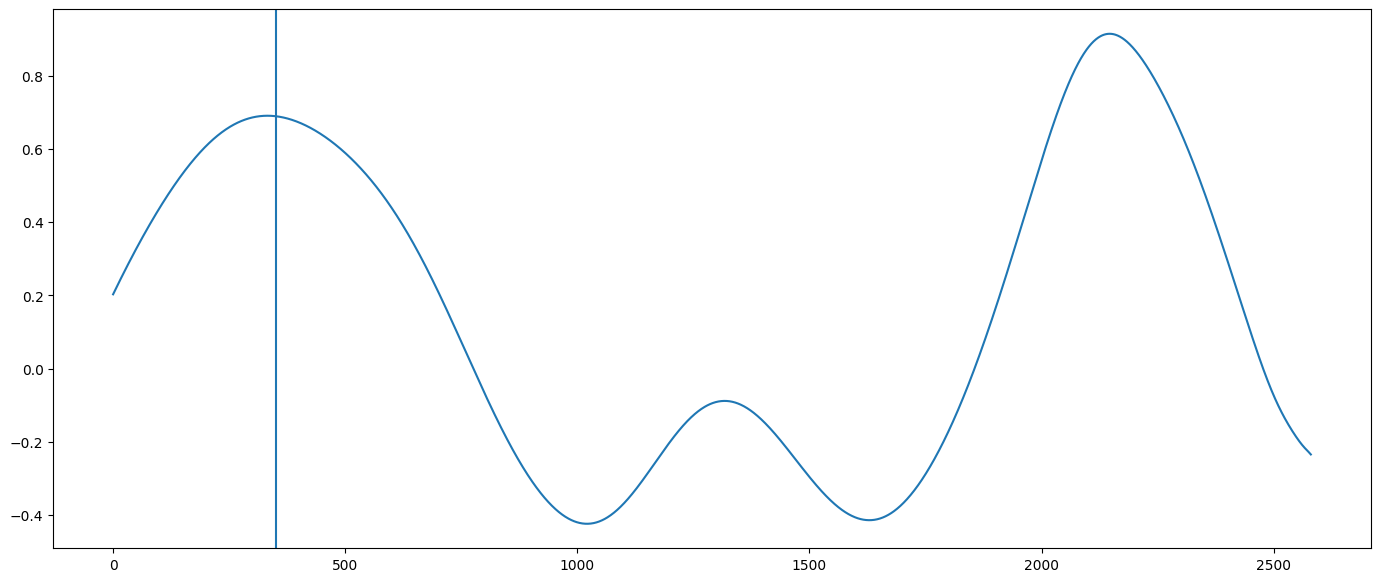

In [59]:
plt.plot(pearsons)
plt.axvline(350)

In [60]:
np.where(pearsons==np.array(pearsons).max())[0][0]

2147

In [61]:
pearsons[2147]

0.9148610541147132

In [62]:
# 计算相关系数
# pearsonr(aavso_point2[0:np.where(time_aavso==np.max(time_aavso))[0][0]], EW_inter[np.where(time_EW==np.min(time_aavso))[0][0]:-3])
pearsonr(aavso_point2[np.where(time_aavso==np.min(time_EW))[0][0]-2:-1], EW_inter)[0]


ValueError: x and y must have the same length.

In [63]:
len(aavso_point2[np.where(time_aavso==np.min(time_EW))[0][0]:-1])

2270

In [64]:
len(aavso_point2[np.where(time_aavso==np.min(time_EW))[0][0]:np.where(time_aavso==np.max(time_EW))[0][0]])

1836

In [65]:
len(EW_inter)

1837

In [66]:
(JD_ccc_aavso[0]-JD_ccc_bfosc[0]+0.2147*(-JD_bfosc.min()+df_use['JD'].max()))/0.0547

4.819279609978458

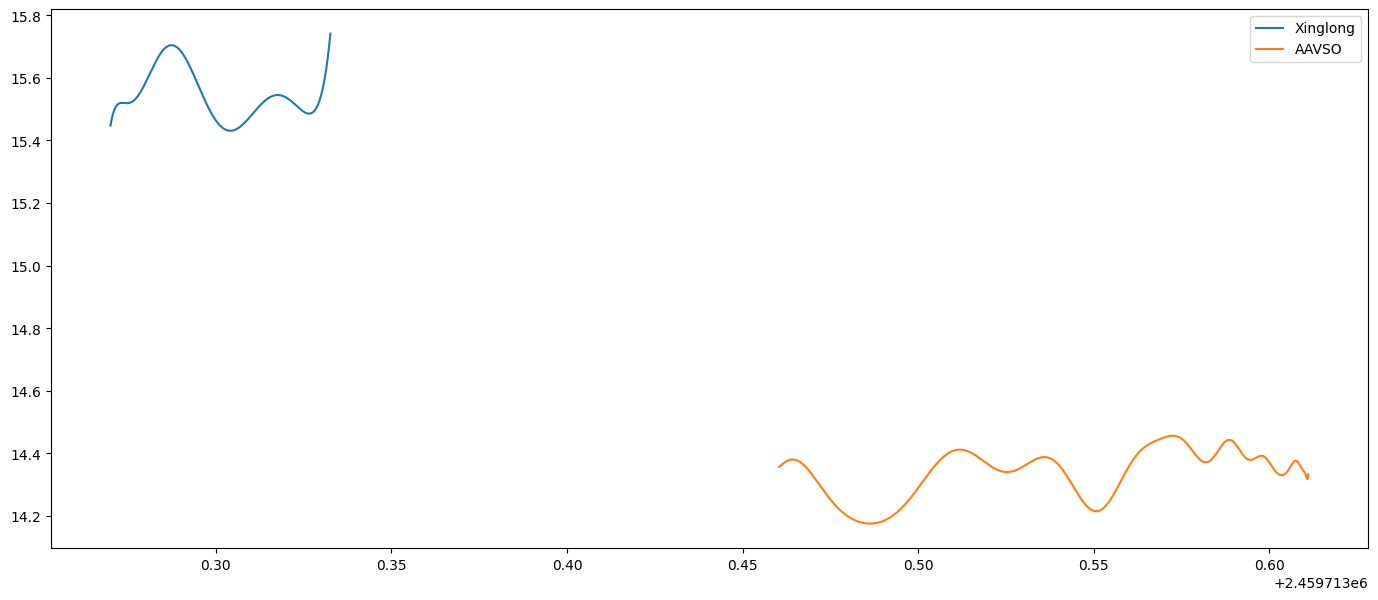

In [67]:
plt.plot(JD_ccc_bfosc, -EW_inter/10+14, label='Xinglong')
plt.plot(JD_ccc_aavso, aavso_point2, label='AAVSO')
plt.legend()